<a href="https://colab.research.google.com/github/Shashankabasani/SPAM-SMS-DETECTION/blob/main/SPAM_SMS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
pip install numpy pandas scikit-learn

In [40]:
# Importing necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [41]:

csv_path = '/content/spam.csv'

encodings = ['utf-8', 'ISO-8859-1', 'latin1']
for encoding in encodings:
    try:
        df = pd.read_csv(csv_path, encoding=encoding)
        print("CSV file successfully read with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Error reading with encoding:", encoding)

print(df.head())

Error reading with encoding: utf-8
CSV file successfully read with encoding: ISO-8859-1
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [42]:
selected_columns = df.iloc[:, :2]
selected_columns.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [43]:
ham_count = (selected_columns == 'ham').sum()
spam_count = (selected_columns == 'spam').sum()

print("Number of 'ham' entries:", ham_count)
print("Number of 'spam' entries:", spam_count)

Number of 'ham' entries: v1    4825
v2       0
dtype: int64
Number of 'spam' entries: v1    747
v2      0
dtype: int64


In [44]:

selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [45]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

selected_columns['v2'] = selected_columns['v2'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
selected_columns['v2'] = selected_columns['v2'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

selected_columns.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-45-bb81ea00bbb5>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-bb81ea00bbb5>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,v1,v2
0,ham,"[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"[Nah, n't, think, goes, usf, ,, lives, around,..."


In [46]:
import plotly.express as px

selected_columns['length'] = selected_columns['v2'].apply(len)

length_count_df = selected_columns.groupby(['v1', 'length']).size().reset_index(name='count')
fig = px.area(length_count_df, x='length', y='count', color='v1', title='Tokenized String Length Distribution',
              labels={'length': 'Tokenized String Length', 'count': 'Frequency'},
              color_discrete_map={'ham': 'rgba(0, 0, 255, 0.5)', 'spam': 'rgba(255, 0, 0, 0.5)'})


fig.show()

<ipython-input-46-22cba5716fa4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Logistic Regression**

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

selected_columns['v2'] = selected_columns['v2'].apply(' '.join)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(selected_columns['v2'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df['v1'] = selected_columns['v1']

<ipython-input-47-f5299b3b42dc>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Columns: 8607 entries, 00 to v1
dtypes: float64(8606), object(1)
memory usage: 365.9+ MB


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import plotly.graph_objects as go


X = tfidf_df.drop(columns=['v1'])
y = tfidf_df['v1']

y = y.apply(lambda label: 1 if label == 'spam' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = logreg_model.predict(X_test)


print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred))

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# create ROC curve plot using Plotly
roc_curve_fig = go.Figure()
roc_curve_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {roc_auc:.2f})'))
roc_curve_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='random classifier'))
roc_curve_fig.update_layout(title='ROC Curve', xaxis_title='false positive rate', yaxis_title='true positive rate')
roc_curve_fig.show()

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, logreg_model.predict_proba(X_test)[:, 1])

# create Precision-Recall curve plot
precision_recall_fig = go.Figure()
precision_recall_fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'))
precision_recall_fig.update_layout(title='Precision-Recall Curve', xaxis_title='Recall', yaxis_title='Precision')
precision_recall_fig.show()

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       965
           1       0.95      0.63      0.76       150

    accuracy                           0.95      1115
   macro avg       0.95      0.81      0.86      1115
weighted avg       0.95      0.95      0.94      1115



In [50]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


In [51]:
import joblib
import warnings

model_filename = 'spam_detection_model.joblib'
joblib.dump(logreg_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as spam_detection_model.joblib


In [52]:
example_strings = [
    "Congratulations, you've won a free vacation! Reply now to claim your prize.",
    "Hi, how are you doing?"
]


loaded_model = joblib.load(model_filename)


predictions = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for example_string in example_strings:
        example_tokens = word_tokenize(example_string)
        example_tokens = [word for word in example_tokens if word.lower() not in stop_words]
        example_text = ' '.join(example_tokens)

        example_tfidf = tfidf_vectorizer.transform([example_text])
        prediction = loaded_model.predict(example_tfidf)

        if prediction[0] == 1:
            predictions.append("Spam")
        else:
            predictions.append("Ham")

for i, prediction in enumerate(predictions):
    print(f"Prediction for example {i+1}: {prediction}")

Prediction for example 1: Spam
Prediction for example 2: Ham


Naive Bayes Model


In [53]:
#Delete unnecessary columns and rename "v1" and "v2
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df.drop(columns_to_drop, inplace=True, axis=1)
df.columns = ["Category", "Message"]

In [54]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [55]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [56]:
#Check if there are duplicated samples in the data
df.duplicated().sum()

403

In [57]:
#Now let's drop the duplicated samples and check it out again
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

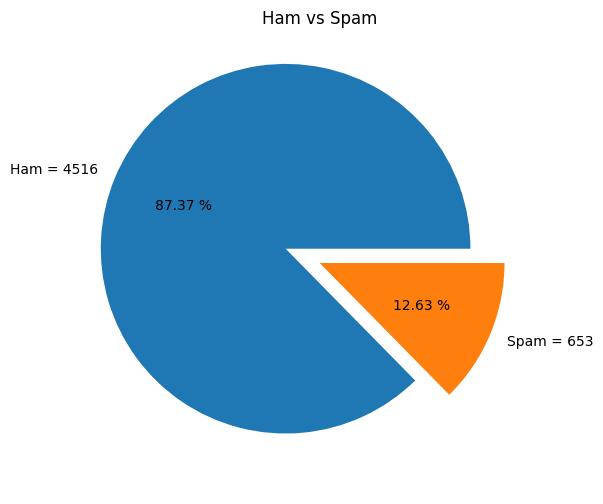

In [58]:
#Visualize Distribution of Email Categories
number_of_spam = df[df['Category'] == 'spam'].shape[0]
number_of_ham = df[df['Category'] == 'ham'].shape[0]

plt.figure(figsize=(7,6))

mail_categories = [number_of_ham, number_of_spam]
labels = [f"Ham = {number_of_ham}", f"Spam = {number_of_spam}"]
explode = [.2, 0]

plt.pie(mail_categories, labels=labels, explode=explode, autopct="%.2f %%")
plt.title("Ham vs Spam")

plt.show()

In [59]:
#Make a 'spam' column and replace spams with 1 and replace hams with 0
encoder = LabelEncoder()
df['spam'] = encoder.fit_transform(df['Category'])
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [60]:
#Now we don't need "Category" column anymore, let's delete it
df.drop('Category', inplace = True, axis = 1)


In [61]:
#Split the data to Train_set and Test_set
x = df['Message']
y = df['spam']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2 , random_state = 42)

In [62]:
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train)

In [63]:
classifier = MultinomialNB()
classifier.fit(x_train_counts, y_train)

MultinomialNB()

In [65]:
#Now, let's create a bag-of-words representation using CountVectorizer, this time for the test data x_test
x_test_counts = vectorizer.transform(x_test)
y_pred = classifier.predict(x_test_counts)

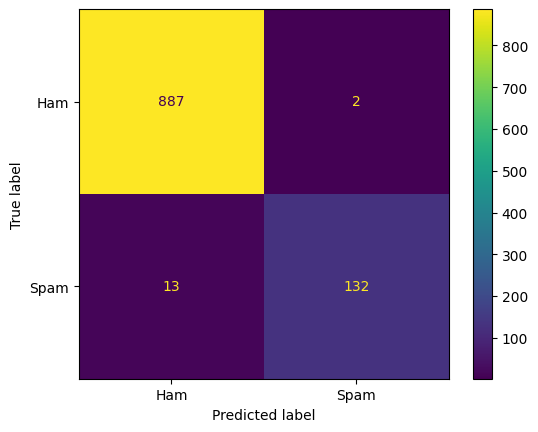

In [66]:
#Display the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Ham", "Spam"])
cm_display.plot()
plt.show()


In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       889
           1       0.99      0.91      0.95       145

    accuracy                           0.99      1034
   macro avg       0.99      0.95      0.97      1034
weighted avg       0.99      0.99      0.99      1034



In [68]:
#Test the model with some emailes
emails = [
    "Hey mohammad, I'm at the Ms.Salahshor class wating for you, where are you?",

    'Upto 20% discount on parking, exclusive offer just for you. Dont miss this reward!',

    '''Join us on Saturday, February 24 at 14:00 UTC on our YouTube channel to take this
    interactive lesson, taught by Tutor Darryl.'''
]

emails_count = vectorizer.transform(emails)
classifier.predict(emails_count)

array([0, 1, 1])

SVM


In [70]:
from subprocess import check_output
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn import svm

In [72]:
email=pd.read_csv("/content/spam.csv",encoding='latin-1')
email=email.rename(columns = {'v1':'label','v2':'message'})
cols=['label','message']
email=email[cols]
email=email.dropna(axis=0, how='any')

#Email preprocessing
num_emails=email["message"].size
def email_processing(raw_email):
    letters_only=re.sub("[^a-zA-Z]"," ",raw_email)
    words=letters_only.lower().split()
    stops=set(stopwords.words("english"))
    m_w=[w for w in words if not w in stops]
    return (" ".join(m_w))


In [73]:

clean_email=[]
for i in range(0,num_emails):
    clean_email.append(email_processing(email["message"][i]))

#Create new dataframe column
email["Processed_Msg"]=clean_email
cols2=["Processed_Msg","label"]
email=email[cols2]

#Create train and test sets
X_train=email["Processed_Msg"][:5000]
Y_train=email["label"][:5000]
X_test=email["Processed_Msg"][5001:5500]
Y_test=email["label"][5001:5500]

In [74]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)

train_data_features=vectorizer.fit_transform(X_train)
train_data_features=train_data_features.toarray()

test_data_features=vectorizer.transform(X_test)
test_data_features=test_data_features.toarray()

#SVM with linear kernel
clf=svm.SVC(kernel='linear',C=1.0)
print ("Training")
clf.fit(train_data_features,Y_train)

print ("Testing")
predicted=clf.predict(test_data_features)
accuracy=np.mean(predicted==Y_test)
print ("Accuracy: ",accuracy)

Training
Testing
Accuracy:  0.9879759519038076


In [76]:
#Validation
X=email["Processed_Msg"][5501:5502]
validation_data=vectorizer.transform(X)
validation_data=validation_data.toarray()

print ("SMS: ",X)
classification=clf.predict(validation_data)
print ("Classification: ",classification)

SMS:  5501    private account statement shows un redeemed po...
Name: Processed_Msg, dtype: object
Classification:  ['spam']
